In [15]:
import numpy as np 
from pathlib import Path
#the line below accesses the file path of the images. Since the main.py file and the archive folder is under the malaria folder, 
#i dont have to write malaria as a part of the file pat
path = Path("archive/cell_images") 
#path.glob gets all the files and folders matching the identifier specified in the argument. it works for with file names,
#and extensions. '*/*.png' includes all subfolders and to not include subfolders its '*.png'
data = list(path.glob('*/*.png'))
uninfected = list(path.glob("Uninfected/*"))
print(len(uninfected))
print(len(data))
print(path.exists())

13780
27558
True


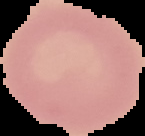

In [16]:
#just wanted to open the images
from PIL import Image
import PIL
PIL.Image.open(uninfected[1])

In [17]:
#resizing images to standardize the data because it leads to more consistentcy from the model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#defines transformer and resizes images 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
#loads dataset
dataset = datasets.ImageFolder(root='archive/cell_images', transform=transform)

#split the data into training, validating, and test. validating is used so we can see how the model looks while its training on it itself
#test is used so we can just test the model without seeing whats going on 
train_size = int(0.8 * len(dataset)) #training data is 80% of the dataset
val_size = len(dataset) - train_size #validating data is 20% of the dataset

#randomly splits the data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
from torchvision.transforms import GaussianBlur, Compose, Resize, ToTensor, RandomApply

# Define transforms
train_transforms = Compose([
    Resize((128, 128)),
    RandomApply([GaussianBlur(kernel_size=5)], p=0.5),  # 50% blurred
    ToTensor(),
])

val_transforms = Compose([
    Resize((128, 128)),
    ToTensor(),  # No blur for validation
])

# Apply transforms to your existing train and val datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [26]:
import torch.nn as nn
import torch.nn.functional as func

class NeuralNet(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5) #kernel that scans through the image and creates 12 feature maps
        self.pool = nn.MaxPool2d(2, 2) #creates a 2x2 area that extracts 4 pixels of information and turns it into 1
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 29 * 29, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = func.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [20]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards + optimization:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        max_values, predicted_classes = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")



Epoch [1/5], Loss: 0.0279, Accuracy: 100.00%
Epoch [1/5], Loss: 0.0956, Accuracy: 98.44%
Epoch [1/5], Loss: 0.1880, Accuracy: 97.92%
Epoch [1/5], Loss: 0.2271, Accuracy: 98.44%
Epoch [1/5], Loss: 0.2602, Accuracy: 98.75%
Epoch [1/5], Loss: 0.2830, Accuracy: 98.96%
Epoch [1/5], Loss: 0.3197, Accuracy: 99.11%
Epoch [1/5], Loss: 0.4257, Accuracy: 98.44%
Epoch [1/5], Loss: 0.4789, Accuracy: 98.26%
Epoch [1/5], Loss: 0.4936, Accuracy: 98.44%
Epoch [1/5], Loss: 0.5156, Accuracy: 98.58%
Epoch [1/5], Loss: 0.6077, Accuracy: 98.44%
Epoch [1/5], Loss: 0.6313, Accuracy: 98.56%
Epoch [1/5], Loss: 0.6770, Accuracy: 98.44%
Epoch [1/5], Loss: 0.7176, Accuracy: 98.33%
Epoch [1/5], Loss: 0.9733, Accuracy: 98.24%
Epoch [1/5], Loss: 0.9836, Accuracy: 98.35%
Epoch [1/5], Loss: 0.9889, Accuracy: 98.44%
Epoch [1/5], Loss: 1.0079, Accuracy: 98.52%
Epoch [1/5], Loss: 1.0203, Accuracy: 98.59%
Epoch [1/5], Loss: 1.0377, Accuracy: 98.66%
Epoch [1/5], Loss: 1.0507, Accuracy: 98.72%
Epoch [1/5], Loss: 1.0792, Accu

In [ ]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    
print(f"Test Accuracy: {100* test_correct / test_total:.2f}%")

Test Accuracy: 98.11%
